In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define data transformations (convert images to tensors & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l2 = nn.Linear(28 * 28, 128, bias=True)  # Input: 784 → Hidden: 128
        self.l3 = nn.Linear(128, 64, bias=True)       # Hidden: 128 → Hidden: 64
        self.l4 = nn.Linear(64, 10, bias=True)        # Hidden: 64 → Output: 10

        # Unique weights for each of the 784 input activations
        self.custom_weights = nn.Parameter(torch.randn(28 * 28))  # Shape: (784,)
        print(self.custom_weights)

    def forward(self, im):
        
        l1 = im.view(-1, 28 * 28) 

        l2 = F.relu(self.l2(l1))

        l3 = torch.matmul(l2, self.l3.weight.T)
        weighted_sum = (self.custom_weights * l1).sum(dim=1) 
        l3[:, 0] += weighted_sum 
        l3 += self.l3.bias 
        l3 = F.relu(l3)

        l4 = self.l4(l3)
        
        return l4

# Initialize model
model = MNIST_Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create dummy input for debugging
dummy_input = torch.randn(2, 1, 28, 28)  # Batch size 2, 1 channel, 28x28 i(mage
dummy_output = model(dummy_input)


Parameter containing:
tensor([ 1.8380e+00,  5.5357e-01,  1.1535e+00,  2.7591e+00,  4.9574e-01,
         6.2476e-01,  9.0559e-01,  4.7285e-01, -7.7836e-01,  1.4725e+00,
        -8.5310e-01, -1.1242e+00, -4.2509e-01,  1.9954e+00,  1.3224e+00,
        -1.2166e+00,  7.0363e-01,  4.0551e-01,  8.3154e-03,  1.7959e+00,
        -7.4149e-01, -1.3418e-01, -3.9223e-01, -1.0468e+00, -1.0611e+00,
         1.8926e+00, -6.2521e-01, -1.5432e+00,  2.2344e+00,  1.2559e+00,
         7.3324e-01, -1.3825e-01, -5.7618e-01, -7.7169e-02, -2.6156e+00,
         3.8954e-01, -2.8627e-01, -7.1167e-01,  1.2902e+00,  4.7400e-01,
         1.0051e+00,  6.7694e-01,  1.3762e-01,  5.6158e-03, -7.5133e-01,
        -5.6752e-01, -7.8061e-01,  6.1740e-01,  1.6776e+00,  1.3718e+00,
        -4.2293e-01, -2.1519e+00,  2.4071e+00, -2.7544e-01, -3.0617e-02,
         1.5787e-02, -1.0421e-01, -4.7981e-01, -4.6016e-01, -1.3742e-01,
        -1.1334e+00, -5.3344e-01, -5.3080e-01, -3.2067e-01,  7.1205e-01,
        -7.7611e-01, -6.6827e

In [29]:
import torch.optim as optim

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

# Save the model's state_dict
torch.save(model.state_dict(), "./model_weights-c.pth")


Epoch 1/5, Loss: 0.2921
Epoch 2/5, Loss: 0.1129
Epoch 3/5, Loss: 0.0768
Epoch 4/5, Loss: 0.2863
Epoch 5/5, Loss: 0.1769
Training complete!


In [30]:
model.custom_weights

Parameter containing:
tensor([ 1.8695e+00,  5.8504e-01,  1.1850e+00,  2.7905e+00,  5.2721e-01,
         6.5623e-01,  9.3706e-01,  5.0432e-01, -7.4689e-01,  1.5039e+00,
        -8.2164e-01, -1.0927e+00, -3.9306e-01,  2.0282e+00,  1.3539e+00,
        -1.1852e+00,  7.3510e-01,  4.3698e-01,  3.9782e-02,  1.8274e+00,
        -7.1002e-01, -1.0271e-01, -3.6076e-01, -1.0154e+00, -1.0296e+00,
         1.9240e+00, -5.9374e-01, -1.5117e+00,  2.2659e+00,  1.2874e+00,
         7.6471e-01, -1.0679e-01, -5.4471e-01, -4.5698e-02, -2.5840e+00,
         4.2135e-01, -2.5442e-01, -6.7966e-01,  1.3232e+00,  5.0708e-01,
         1.0391e+00,  7.1078e-01,  1.6990e-01,  3.7673e-02, -7.1836e-01,
        -5.3480e-01, -7.4858e-01,  6.4918e-01,  1.7096e+00,  1.4050e+00,
        -3.9061e-01, -2.1201e+00,  2.4385e+00, -2.4397e-01,  8.4989e-04,
         4.7253e-02, -7.2746e-02, -4.4835e-01, -4.2870e-01, -1.0594e-01,
        -1.1018e+00, -5.0197e-01, -4.9928e-01, -2.8829e-01,  7.4623e-01,
        -7.4053e-01, -6.3185e

In [31]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 96.47%


In [83]:
print(model.l2.weight.shape, model.l3.weight.shape, model.l4.weight.shape)

torch.Size([128, 784]) torch.Size([64, 128]) torch.Size([10, 64])


In [32]:
# Step 1: Take the absolute value of the tensor
l2 = model.l2.weight.abs()
l3 = model.l3.weight.abs()
c = model.custom_weights.abs()
l4 = model.l4.weight.abs()

# Step 2: Sum over the rows (dim=0), resulting in a tensor of shape (784,)
l1 = l2.sum(dim=0)
l2 = l3.sum(dim=0) + l2.sum(dim=1)
l3 = l4.sum(dim=0) + l3.sum(dim=1)
l3[0] = l3[0] + c.sum()
print(l3[0])
l4 = l4.sum(dim=1)

# Step 3: Divide by the number of rows (128) to get the average
l1 = l1 / 128
l2 = l2 / (64 + 784)
l3[1:] = l3[1:] / (10 + 128)
print(l3[1])
l3[0] = l3[0] / (10 + 128 + 784)
print(l3[0])
l4 = l4 / 10

# Print the result
print(l1.shape, l2.shape, l3.shape, l4.shape)  


tensor(608.0300, grad_fn=<SelectBackward0>)
tensor(0.0604, grad_fn=<SelectBackward0>)
tensor(0.6595, grad_fn=<SelectBackward0>)
torch.Size([784]) torch.Size([128]) torch.Size([64]) torch.Size([10])


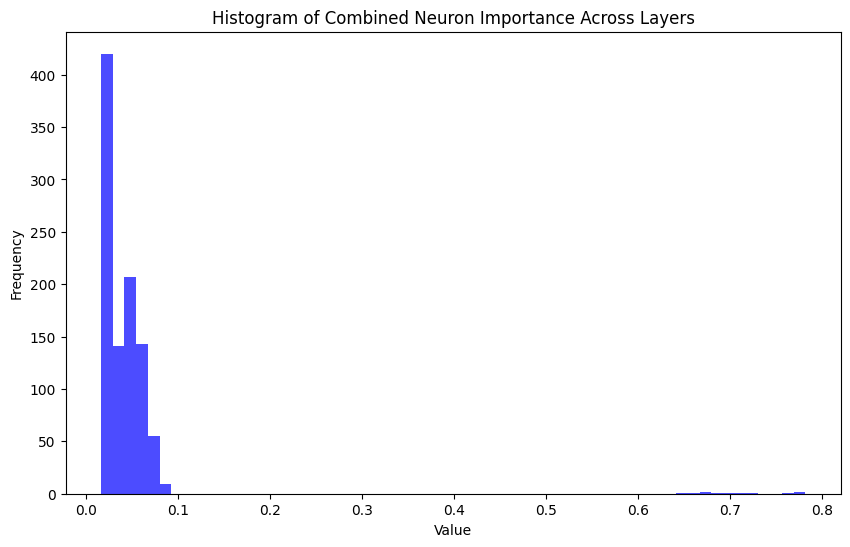

In [33]:
import matplotlib.pyplot as plt

ns = torch.cat((l1, l2, l3, l4))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(ns.detach().numpy(), bins=60, color="blue", alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Neuron Importance Across Layers')

# Show the plot
plt.show()

In [34]:
len(ns)

986

In [35]:
len([x for x in ns if x >= ns.mean()])

373

In [36]:
len([x for x in l1 if x >= ns.mean()])

240

In [37]:
len([x for x in l2 if x >= ns.mean()])

62

In [38]:
len([x for x in l3 if x >= ns.mean()])

61

In [39]:
len([x for x in l4 if x >= ns.mean()])

10

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def remove_neurons_from_layer(layer, neurons_to_remove):
    """
    Removes specified neurons from a given fully connected layer.
    
    Args:
        layer (nn.Linear): The original layer to modify.
        neurons_to_remove (list): List of neuron indices to remove.

    Returns:
        nn.Linear: A new layer with the specified neurons removed.
    """
    neurons_to_remove = sorted(neurons_to_remove)

    # Extract current weights and biases
    old_weights = layer.weight.detach().clone()
    old_bias = layer.bias.detach().clone()

    # Create a mask to keep only the rows we want
    keep_indices = [i for i in range(old_weights.shape[0]) if i not in neurons_to_remove]

    # Remove the specified rows
    new_weights = old_weights[keep_indices, :]
    new_bias = old_bias[keep_indices]

    # Create new Linear layer with adjusted output size
    new_layer = nn.Linear(layer.in_features, len(keep_indices), bias=True)

    # Copy the modified weights and biases into the new layer
    with torch.no_grad():
        new_layer.weight.copy_(new_weights)
        new_layer.bias.copy_(new_bias)

    return new_layer


class CustomNet(nn.Module):
    def __init__(self, input_size=784, remove_pixels=[], remove_neurons=[]):
        super(CustomNet, self).__init__()

        self.remove_pixels = remove_pixels  # Store pixels to remove

        # **Step 1: Remove specified neurons from the first hidden layer (l1)**
        self.l2 = nn.Linear(input_size - len(self.remove_pixels), 128)  # Adjusted input size
        self.l2 = remove_neurons_from_layer(self.l2, r2)  # Apply neuron removal

        # **Step 2: Define next layers after neuron removal is applied**
        self.l3 = nn.Linear(self.l2.out_features, 64)  # l2 takes the output from l1
        self.l3 = remove_neurons_from_layer(self.l3, r3)

        self.l4 = nn.Linear(self.l3.out_features, 10)  # l3 takes the output from l2
        self.l4 = remove_neurons_from_layer(self.l4, r4)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input (batch_size, 784)

        # **Step 1: Remove selected pixels from input layer**
        if self.remove_pixels:
            keep_indices = [i for i in range(784) if i not in self.remove_pixels]
            x = x[:, keep_indices] 

        # **Step 2: Forward pass through the network**
        l2_out = F.relu(self.l2(x))
        l3_out = F.relu(self.l3(l2_out))
        l4_out = self.l4(l3_out)

        return l4_out

if len([x for x in l1 if x >= ns.mean()]) > 0: 
    pixels_to_remove = [i for i, x in enumerate(ns[:len(l1)]) if x < ns.mean()]
r2 = [i for i, x in enumerate(ns[len(l1): len(l1) + len(l2)]) if x < ns.mean()]
r3 = [i for i, x in enumerate(ns[len(l1) + len(l2): len(l1) + len(l2) + len(l3)]) if x < ns.mean()]
r4 = [i for i, x in enumerate(ns[len(l1) + len(l2) + len(l3): len(l1) + len(l2) + len(l3) + len(l4)]) if x < ns.mean()]

# Initialize model with adjusted input size and neurons removed
model = CustomNet(remove_pixels=pixels_to_remove)


In [61]:
# Find indices of values that are greater than or equal to the mean
pixels_to_remove = [i for i, x in enumerate(ns[:784]) if x < ns.mean()]
r2 = [i for i, x in enumerate(ns[784: 784 + 128]) if x < ns.mean()]
r3 = [i for i, x in enumerate(ns[784 + 128: 784 + 128 + 60]) if x < ns.mean()]
r4 = [i for i, x in enumerate(ns[784 + 128 + 60: 784 + 128 + 60 + 10]) if x < ns.mean()]

# Print the resulting lists of indices
print("Pixels to remove (input layer):", pixels_to_remove)
print("r2 (first hidden layer):", r2)
print("r3 (second hidden layer):", r3)
print("r4 (output layer):", r4)


Pixels to remove (input layer): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 277, 27